# MultiDVPS: Depth-Aware Video Panoptic Segmentation

This notebook demonstrates the use of the MultiDVPS model. We start by loading some checkpoint, then visualize aspects
of the outputs during both traning and inference.

[11/12 14:03:10 unipercept.trainer]: Initializing Trainer: multidvps @ cityscapes/resnet50/2023-11-12_14-03-09@gcn8.local.snellius.surf.nl
[11/12 14:03:10 unipercept.trainer]: Using directory: /gpfs/work4/0/einf5438/outputs/multidvps/cityscapes/resnet50/2023-11-12_14-03-09@gcn8.local.snellius.surf.nl


[11/12 14:03:10 unipercept.trainer]: Using accelerator: 
{'automatic_checkpoint_naming': True,
 'iteration': 0,
 'logging_dir': '/gpfs/work4/0/einf5438/outputs/multidvps/cityscapes/resnet50/2023-11-12_14-03-09@gcn8.local.snellius.surf.nl/logs',
 'project_dir': '/gpfs/work4/0/einf5438/outputs/multidvps/cityscapes/resnet50/2023-11-12_14-03-09@gcn8.local.snellius.surf.nl/outputs',
 'save_on_each_node': False,
 'total_limit': 4}
[11/12 14:03:10 unipercept.trainer]: Current process: 0 / 1
Could not recover model from training session: FileNotFoundError(2, 'No such file or directory')
[11/12 14:03:10 unipercept.data.collect]: Using adjacent collector (2 frames) with required sources (frozenset({'image', 'panoptic'}), frozenset({'image', 'panoptic'}))
[11/12 14:03:10 unipercept.data]: Wrapping dataset: CityscapesVPSDataset(queue_fn=GroupAdjacentTime(num_frames=2, use_typecheck=False), split='train', root='//datasets/cityscapes-vps', all=False)
[11/12 14:03:11 unipercept.data.collect]: Found 2

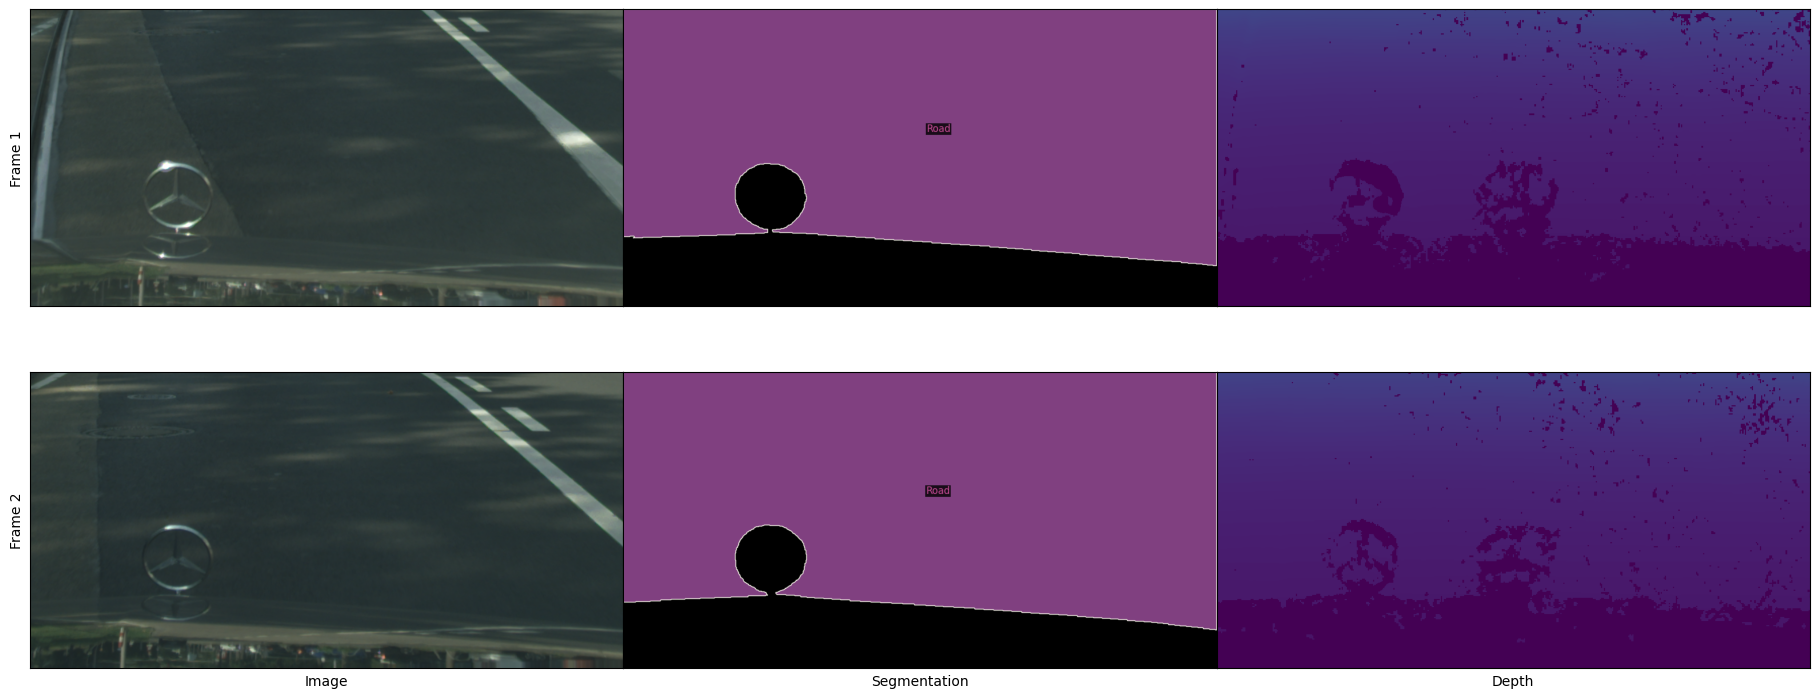

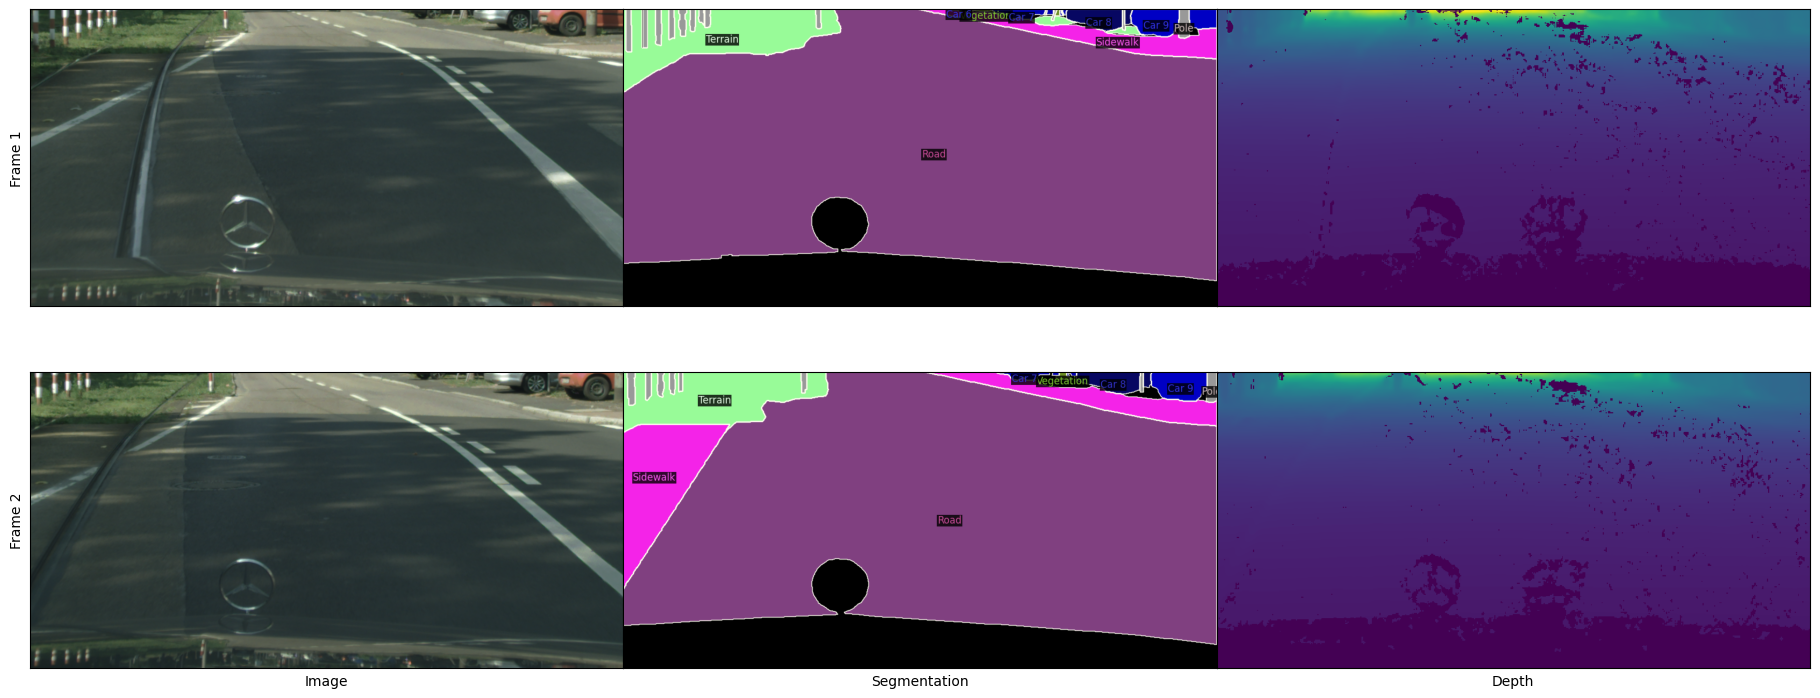

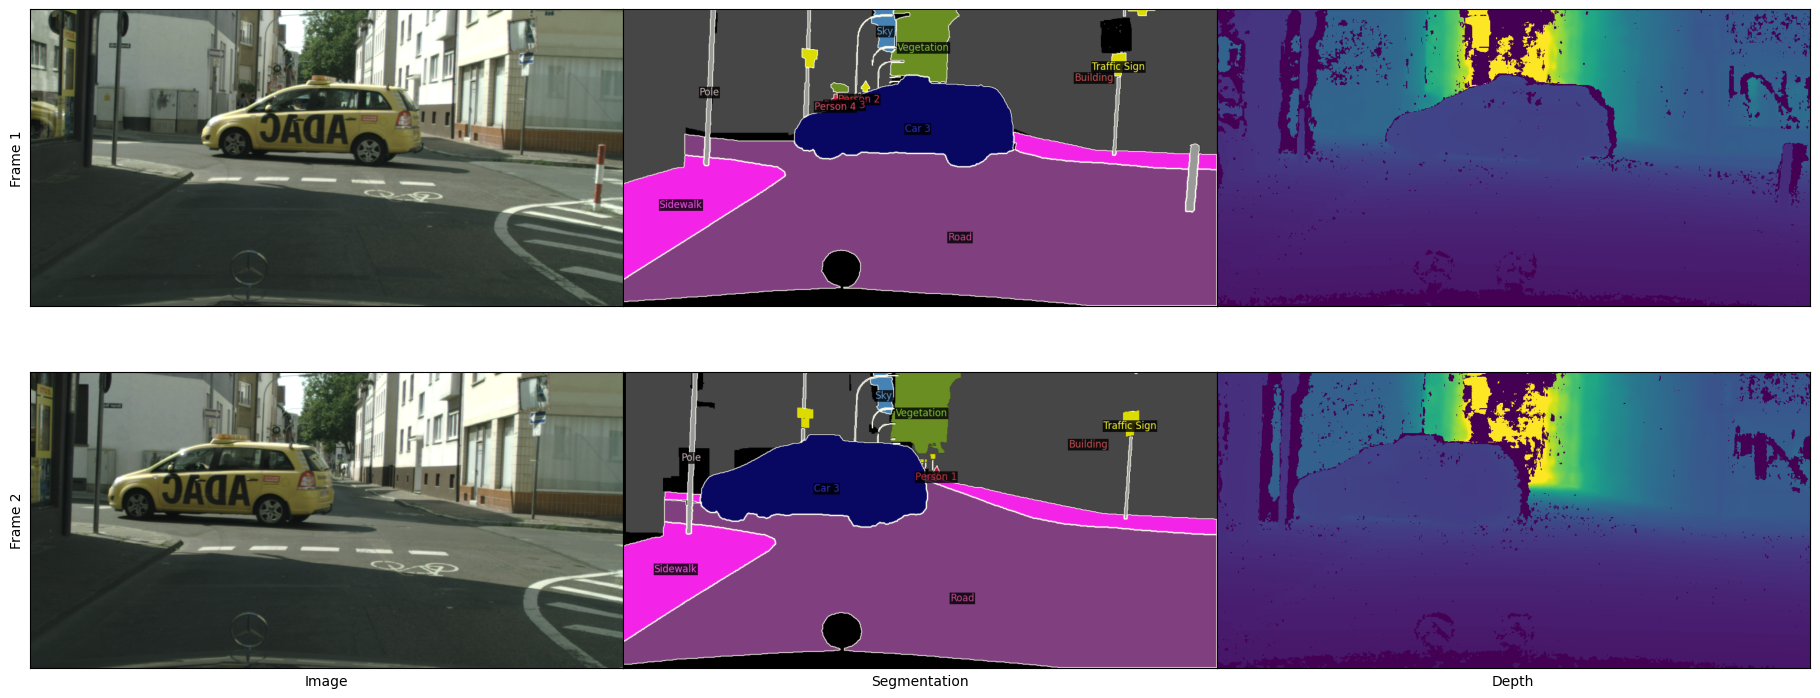

In [2]:
import unipercept as up
import unimodels.multidvps as multidvps
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn 
config = up.read_config('../configs/cityscapes/multidvps_resnet50.py')
model: multidvps.MultiDVPS = up.create_model(config)
dataset, info = up.prepare_dataset(config, "train")

for _ in range(3):
    inputs =next(dataset)
    up.render.utils.plot_input_data(inputs[0], info=info)
pass

## Parameter count

We count the model parameters for each submodule.

In [3]:
def get_parameter_count(module: nn.Module) -> tuple[int,int]:
    """
    Returns the number of trainable and total (including non-trainable) parameters of a module.
    """
    trainable = sum(p.numel() for p in module.parameters() if p.requires_grad)
    total = sum(p.numel() for p in module.parameters())
    return trainable, total

def make_human_readble(num: int) -> str:
    """
    Returns the integer in a human readable format, e.g. 1000 -> 1K, 1000000 -> 1M.
    """

    for unit in ["", "k"]:
        if abs(num) < 1000.0:
            return f"{num:.2f} {unit}"
        num /= 1000.0
    return f"{num:.2f} M"

def print_param_counts(mod: nn.Module, max_depth: int, *, cur_depth=0):
    """
    Prints the number of trainable and total (including non-trainable) parameters of a module and its submodules.
    """
    if cur_depth > max_depth:
        return
    trainable, total = get_parameter_count(mod)
    if total == 0:
        return
    indent = "    " * cur_depth
    name = indent + f"- {mod.__class__.__name__}"
    spacing = max(50 - len(name), 0) * " "
    print(f"{name}{spacing} : {make_human_readble(total):10s} -> {make_human_readble(trainable):10s}")
    for submod in mod.children():
        print_param_counts(submod, max_depth, cur_depth=cur_depth+1)

print_param_counts(model, 6)

- MultiDVPS                                        : 37.54 M    -> 14.03 M   
    - FeaturePyramidBackbone                       : 27.43 M    -> 3.92 M    
        - TimmBackbone                             : 23.51 M    -> 0.00      
            - FeatureGraphNet                      : 23.51 M    -> 0.00      
                - ResNet                           : 23.51 M    -> 0.00      
                    - Conv2d                       : 9.41 k     -> 0.00      
                    - BatchNorm2d                  : 128.00     -> 0.00      
                    - Module                       : 215.81 k   -> 0.00      
                        - Module                   : 75.01 k    -> 0.00      
                        - Module                   : 70.40 k    -> 0.00      
                        - Module                   : 70.40 k    -> 0.00      
                    - Module                       : 1.22 M     -> 0.00      
                        - Module                   : 379.39 k   

To ensure compatability with specialized optimizers, e.g. fused adam, we list the unique parameter datatypes below.

In [10]:
unique_param_dtypes = set()
for name, param in model.cuda().named_parameters():
    unique_param_dtypes.add(param.dtype)

print(f"Unique parameter dtypes: {unique_param_dtypes}")

Unique parameter dtypes: {torch.float32}


## Training forward pass

In [5]:
ctx = model._forward_common(inputs)
print(ctx)

Context(
    captures=CaptureData(
        depths=Tensor(shape=torch.Size([2, 512, 1024]), device=cpu, dtype=torch.float32, is_shared=False),
        images=Tensor(shape=torch.Size([2, 3, 512, 1024]), device=cpu, dtype=torch.uint8, is_shared=False),
        segmentations=Tensor(shape=torch.Size([2, 512, 1024]), device=cpu, dtype=torch.int64, is_shared=False),
        times=Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, is_shared=False),
        batch_size=torch.Size([2]),
        device=None,
        is_shared=False),
    detections=TensorDict(
        fields={
            fpn.3: Detection(
                kernel_spaces=TensorDict(
                    fields={
                        multi: Tensor(shape=torch.Size([2, 256, 32, 64]), device=cpu, dtype=torch.float32, is_shared=False)},
                    batch_size=torch.Size([2]),
                    device=cpu,
                    is_shared=False),
                stuff_map=Tensor(shape=torch.Size([2, 19, 32, 64]), dev

In [6]:
truths = model.training_pipeline.true_segmentation(ctx)

print(truths)

Truths(
    insmap=Tensor(shape=torch.Size([2, 128, 256]), device=cpu, dtype=torch.int64, is_shared=False),
    semmap=Tensor(shape=torch.Size([2, 128, 256]), device=cpu, dtype=torch.int64, is_shared=False),
    stuff=TensorDict(
        fields={
            fpn.3: Stuff(
                indices=Tensor(shape=torch.Size([2, 19]), device=cpu, dtype=torch.bool, is_shared=False),
                labels=Tensor(shape=torch.Size([2, 19, 128, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                masks=Tensor(shape=torch.Size([2, 19, 32, 64]), device=cpu, dtype=torch.bool, is_shared=False),
                scoremap=Tensor(shape=torch.Size([2, 19, 32, 64]), device=cpu, dtype=torch.float32, is_shared=False),
                batch_size=torch.Size([2, 19]),
                device=None,
                is_shared=False),
            fpn.4: Stuff(
                indices=Tensor(shape=torch.Size([2, 19]), device=cpu, dtype=torch.bool, is_shared=False),
                labels=Tensor(

fpn.3
fpn.3
fpn.4
fpn.4
fpn.5
fpn.5
fpn.6
fpn.6


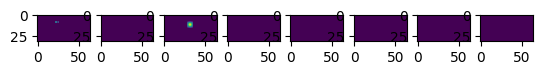

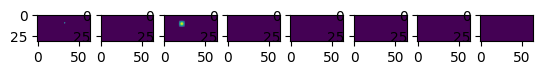

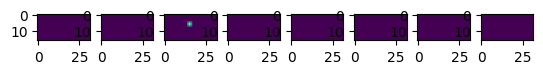

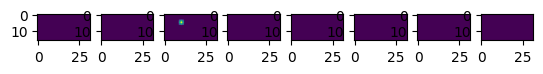

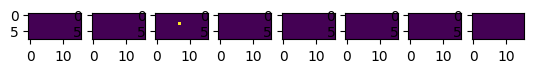

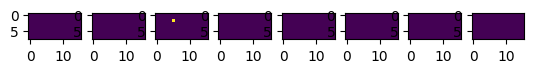

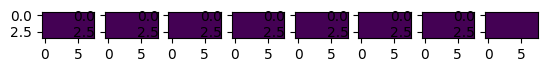

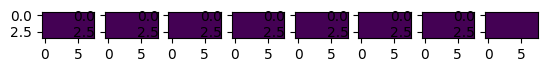

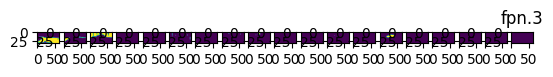

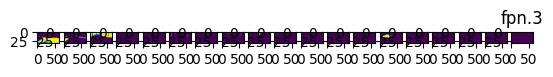

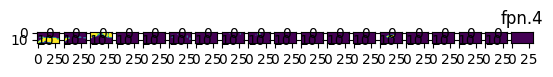

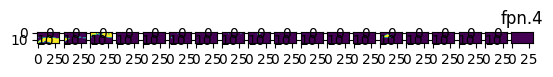

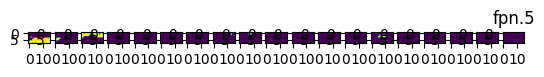

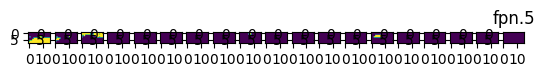

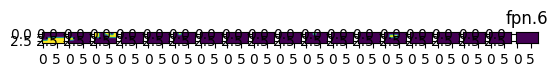

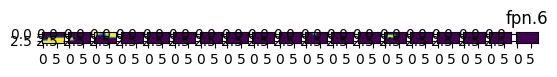

In [7]:
for level, things in truths.thing.items():
    for things in things:
        print(level)
        
        fig, ax = plt.subplots(1, things.scoremap.shape[0], squeeze=False)
        for i, scoremap in enumerate(things.scoremap):
            ax[0, i].imshow((scoremap.cpu()))
for level, stuff in truths.stuff.items():
    for stuff in stuff:
        fig, ax = plt.subplots(1, stuff.scoremap.shape[0], squeeze=False)
        for i, scoremap in enumerate(stuff.scoremap):
            ax[0, i].imshow((scoremap.cpu()))
        plt.title(level)

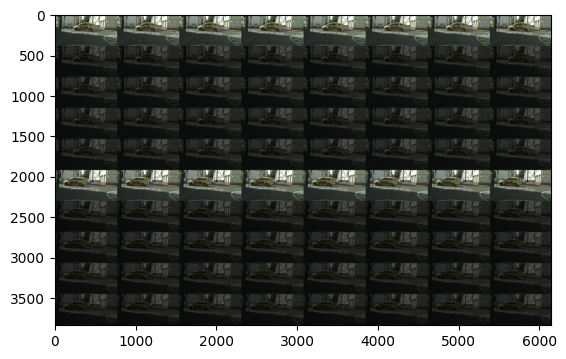

In [8]:
vis = multidvps.visuals.visualize_true_things(ctx.captures.images, list(truths.thing.values()))
plt.imshow(vis.permute(1,2,0) / 255)

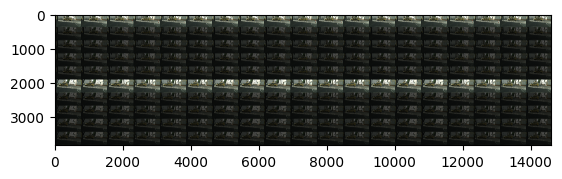

In [9]:
vis = multidvps.visuals.visualize_true_stuff(ctx.captures.images, list(truths.stuff.values()))

plt.imshow(vis.permute(1,2,0) / vis.max())